In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import tikzplotlib

In [20]:
# This section is just me figuring out how tensors work
#lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
#upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
#x = tf.random.uniform(shape=[1,100]) # Interior points
#training_pts = tf.concat([lower_bound, x, upper_bound], 1) # Actual training data
#x_0 = tf.slice(training_pts, [0,0], [1,1])
#x_1 = tf.slice(training_pts, [0,101], [1,1])
#print(x_0.numpy(), x_1.numpy())

In [57]:
# Construct Simple Feedforward Network
model = Sequential()
model.add(Dense(100, input_shape=[1], activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
# Define Loss Function
def loss_fn(model,x):
    #print(x)
    with tf.GradientTape() as tt:
        tt.watch(x)
        with tf.GradientTape() as t:
            t.watch(x)
            f = model(x, training=True)
            #print('f = ', f)
        df_dx = t.gradient(f,x)
        #print(df_dx)
    d2f_dx2 = tt.gradient(df_dx,x)
    #print(d2f_dx2)
    
    u_0 = tf.zeros(shape=[1,1]) # Lower boundary condition
    u_1 = tf.ones(shape=[1,1]) # Upper boundary condition
    bound_weight = 1
    mse = tf.keras.losses.MeanSquaredError()
    lower_bound_error = tf.math.subtract(tf.slice(f,[0,0],[1,1]),u_0)
    #print(lower_bound_error)
    upper_bound_error = tf.math.subtract(tf.slice(f,[99,0], [1,1]),u_1)
    loss_1 = tf.math.add(tf.nn.l2_loss(d2f_dx2), 
                       tf.nn.l2_loss(bound_weight*lower_bound_error))
    loss = tf.math.add(loss_1, tf.nn.l2_loss(bound_weight*upper_bound_error))
    return loss

In [58]:
# Train network
optimizer = tf.keras.optimizers.Adam() # Fancy gradient decent
epochs = 20
train_loss_results = [] # For tracking loss during training
iterations_per_epoch = 100
minibatch_size = 100 # Number of points to be selected each iteration
for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for iteration in range(iterations_per_epoch):
        lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
        upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
        interior_pts = tf.random.uniform(shape=[1,minibatch_size-2]) # Interior points
        x = tf.transpose(tf.concat([lower_bound, interior_pts, upper_bound], 1)) # Actual training data
        with tf.GradientTape() as t:
            t.watch(x)
            #print(x)
            #f = model(x, training=True) # Estimate for u
            loss = loss_fn(model,x) # Loss
        grads = t.gradient(loss, model.trainable_weights) # Find model gradients
        optimizer.apply_gradients(zip(grads,model.trainable_weights)) # Perform gradient decent
        epoch_loss_avg.update_state(loss) # Track loss
    # End Epoch
    train_loss_results.append(epoch_loss_avg.result())
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

Epoch 000: Loss: 0.089
Epoch 001: Loss: 0.001
Epoch 002: Loss: 0.000
Epoch 003: Loss: 0.000
Epoch 004: Loss: 0.000
Epoch 005: Loss: 0.000
Epoch 006: Loss: 0.000
Epoch 007: Loss: 0.000
Epoch 008: Loss: 0.000
Epoch 009: Loss: 0.000
Epoch 010: Loss: 0.000
Epoch 011: Loss: 0.000
Epoch 012: Loss: 0.000
Epoch 013: Loss: 0.000
Epoch 014: Loss: 0.000
Epoch 015: Loss: 0.000
Epoch 016: Loss: 0.000
Epoch 017: Loss: 0.000
Epoch 018: Loss: 0.000
Epoch 019: Loss: 0.000


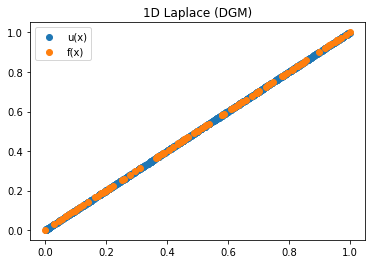

In [59]:
# Run the model with real data
lower_bound = tf.zeros(shape=[1,1]) # Lower bound u(0)=0
upper_bound = tf.ones(shape=[1,1]) # Upper bound u(1)=1
x = tf.random.uniform(shape=[1,98]) # Interior points
test_points_tensor = tf.transpose(tf.concat([lower_bound, x, upper_bound], 1)) # Actual data
test_points = test_points_tensor.numpy()
f = model(test_points_tensor, training=False).numpy()
x_actual = tf.random.uniform(shape=[1,1000]).numpy() # Known solution
#print(test_points[0])
#print(f[0])
plt.title('1D Laplace (DGM)')
plt.scatter(x_actual,x_actual, label='u(x)')
plt.scatter(test_points,f, label='f(x)')
plt.legend()

tikzplotlib.save("1d_laplace_dgm.tex")
